In [67]:
import keras ,os  
from keras.layers import Dense,Conv2D,MaxPool2D,Activation,Dropout,Flatten,BatchNormalization
from keras import Sequential
import tensorflow  as tf 
from cv2 import cv2
import  matplotlib.pyplot  as plt 
import  matplotlib.image  as mpimg

os.environ['CUDA_VISIBLE_DEVICES']='0'
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image 
import pandas as pd 
import numpy as np
# 設定自動增長 GPU 記憶體用量
gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 Session
tf.compat.v1.keras.backend.set_session(sess)

#data_loader
train_data = keras.preprocessing.image_dataset_from_directory(
    '.\image_data/train',
    labels='inferred', 
    batch_size= 128,
    label_mode = 'categorical',
    color_mode = 'grayscale',
    class_names = ['0','1','2','3','4'],
    image_size = (64,64),
    shuffle=True,
    seed = 123,
    validation_split = 0.2,
    subset = 'training')

valid_data = keras.preprocessing.image_dataset_from_directory(
    '.\image_data/train',
    labels='inferred', 
    batch_size= 128,
    label_mode = 'categorical',
    color_mode = 'grayscale',
    class_names = ['0','1','2','3','4'],
    image_size = (64,64),
    shuffle=True,
    seed = 123,
    validation_split = 0.2,
    subset = 'validation')
#影像處理
def transform (x,y):
    image = tf.image.random_brightness(x,max_delta = 0.05)#亮度調節
    image = ImageDataGenerator()
    return image,y

#train_data = train_data.map(transform)

In [29]:
num_class = 5
#CNN
model = Sequential()
model.add(Conv2D(32,(3,3), strides = (1,1) , padding = 'same',input_shape = (32,32,3)))
model.add(Activation('relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Conv2D(64,(5,5), strides = (1,1) , padding = 'same'))
model.add(Activation('relu'))
model.add(MaxPool2D(2,2))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Conv2D(64,(3,3), strides = (1,1) , padding = 'same'))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())


model.add(Conv2D(32,(3,3), strides = (1,1) , padding = 'same'))
model.add(Activation('relu'))


model.add(Flatten())

model.add(Dense(784))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(10))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(num_class))
model.add(Activation('softmax'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_59 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
activation_60 (Activation)   (None, 16, 16, 64)      

In [30]:
#後來沒有使用
model_DNN = Sequential()
model_DNN.add(keras.layers.Input(shape=(32,32,3)))
model_DNN.add(Dense(units = 1024,input_dim = 3072,
            kernel_initializer='normal',
            activation = 'relu'))

model_DNN.add(Dense(units = 512 ,
            kernel_initializer='normal',
            activation = 'relu'))

model_DNN.add(Dense(units = 256 ,
            kernel_initializer='normal',
            activation = 'relu'))

model_DNN.add(Flatten())
model_DNN.add(Dense(units =5,
            kernel_initializer='normal',
            activation = 'softmax'))

print(model_DNN.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 32, 32, 1024)      4096      
_________________________________________________________________
dense_39 (Dense)             (None, 32, 32, 512)       524800    
_________________________________________________________________
dense_40 (Dense)             (None, 32, 32, 256)       131328    
_________________________________________________________________
flatten_11 (Flatten)         (None, 262144)            0         
_________________________________________________________________
dense_41 (Dense)             (None, 5)                 1310725   
Total params: 1,970,949
Trainable params: 1,970,949
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
#optimizers = keras.optimizers.SGD(momentum=0.9)
optimizers = keras.optimizers.SGD(lr = 1e-3 , momentum= 0.9)

model.compile(loss = keras.losses.categorical_crossentropy,optimizer=optimizers,metrics=['accuracy'])
#model_DNN.compile(loss = keras.losses.categorical_crossentropy,optimizer=optimizers,metrics=['accuracy'])

In [40]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split=0.2)
#Test Generator，只Rescale，不需要其他增強
test_datagen = ImageDataGenerator(rescale = 1./255,
    validation_split=0.2)


training_set = train_datagen.flow_from_directory('.\image_data/train/',
                                                 target_size = (32, 32),
                                                 batch_size = 32,
                                                 #color_mode ='grayscale',
                                                 class_mode = 'categorical',
                                                 shuffle=True,subset='training')

test_set = test_datagen.flow_from_directory('.\image_data/train/',
                                            target_size = (32, 32),
                                            batch_size = 32,
                                            #color_mode ='grayscale',
                                            class_mode = 'categorical',
                                            shuffle=True,
                                            subset='validation')

checkpoint = keras.callbacks.ModelCheckpoint(
    './', monitor='val_accuracy',
     verbose=2, save_best_only=True,
     save_weights_only = False, mode='max')
callbacks_list = [checkpoint]

Found 2260 images belonging to 5 classes.
Found 563 images belonging to 5 classes.


In [41]:
history  =  model.fit(training_set,lr = 1e-4, steps_per_epoch = 25,epochs= 250,validation_data = test_set,validation_steps = 1,callbacks = callbacks_list,verbose=1)
model.save('cnn1104_2.h5')
#history_DNN  =  model_DNN.fit(training_set,steps_per_epoch = 25,epochs= 250,validation_data = test_set,validation_steps = 1,callbacks = callbacks_list,verbose=1)
#model_DNN.save('dnn1104_1.h5')

Epoch 1/250
25/25 [==============================] - ETA: 0s - loss: 0.5427 - accuracy: 0.7875
Epoch 00001: val_accuracy improved from -inf to 0.65625, saving model to .\
INFO:tensorflow:Assets written to: .\assets
25/25 [==============================] - 6s 220ms/step - loss: 0.5427 - accuracy: 0.7875 - val_loss: 0.8337 - val_accuracy: 0.6562
Epoch 2/250
25/25 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.7850
Epoch 00002: val_accuracy did not improve from 0.65625
25/25 [==============================] - 1s 49ms/step - loss: 0.5770 - accuracy: 0.7850 - val_loss: 0.9591 - val_accuracy: 0.6250
Epoch 3/250
25/25 [==============================] - ETA: 0s - loss: 0.5518 - accuracy: 0.7881
Epoch 00003: val_accuracy improved from 0.65625 to 0.81250, saving model to .\
INFO:tensorflow:Assets written to: .\assets
25/25 [==============================] - 5s 212ms/step - loss: 0.5518 - accuracy: 0.7881 - val_loss: 0.4992 - val_accuracy: 0.8125
Epoch 4/250
25/25 [======

#繪製圖表

No handles with labels found to put in legend.


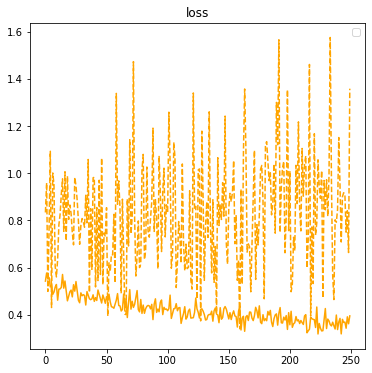

No handles with labels found to put in legend.


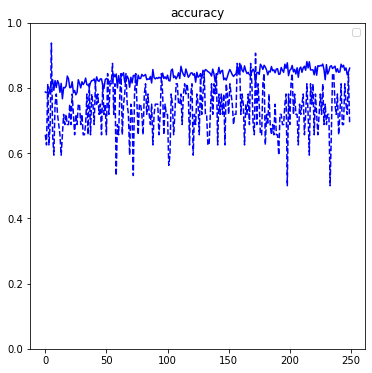

accuracy: 0.8807106614112854 
val_accuracy: 0.9375


In [45]:
tra_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
tra_loss =  history.history['loss']
val_loss =  history.history['val_loss']

plt.figure(figsize=(6,6))

plt.plot(range(len(tra_loss)),tra_loss,'-',c = 'orange')
plt.plot(range(len(val_loss)),val_loss,'--',c = 'orange')

plt.title('loss')
plt.legend(loc='best')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(range(len(tra_acc)),tra_acc,'-',c = 'b')
plt.plot(range(len(val_acc)),val_acc,'--',c = 'b')

plt.title('accuracy')
plt.legend(loc='best')
plt.ylim(0,1)
plt.show()

print('accuracy:',max(history.history['accuracy']),
       '\nval_accuracy:', max(history.history['val_accuracy']))

預測

In [66]:
#請先讀取模型
model = keras.models.load_model('E:\jupyter\ml_learn\ML100Days/final/cnn1104_2.h5')

In [49]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_59 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
activation_60 (Activation)   (None, 16, 16, 64)      

In [61]:
#彙整test_img
test_list = os.listdir('./image_data/test/')
test_datagen = ImageDataGenerator(rescale=1./255)
test_gener = test_datagen.flow_from_directory('./image_data/test/',
                                                target_size=(32,32),
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False)

Found 2000 images belonging to 1 classes.


In [62]:
#開始預測
pred = model.predict_generator(test_gener, verbose=1)

2000/2000 [==============================] - 3s 2ms/step


In [63]:
#彙整test_id and test_result(flower_class) 並輸出成csv
filenames = test_gener.filenames

result = []
for i in range(len(pred)):
    ind = np.where(pred[i] == np.amax(pred[i]))[0][0]
    result.append(ind)
    
result_df = pd.DataFrame([[i[5:-4] for i in filenames],result]).T
result_df.columns=['id','flower_class']
result_df.to_csv('./result_1104_v2.csv',index=False,header=True)
aaaa=pd.read_csv('./result_1104_V2.csv')
aaaa

,id,flower_class
0,0028624c49b3e0610ff9f1d111f5d532,2
1,002c30700185b7971369258b438070d5,4
2,00852f4f666acecd0c0d140365b42efd,4
3,00c08828fce04e360c732cac01edad9e,4
4,00d366e7877b6a78b104b57d67b60e6b,2
...,...,...
1995,ff7eac29b6d7a33fbd8009677c3e9c58,1
1996,ffbc32a7b67dfe72b8d35d4b1b35fd6c,3
1997,ffea1f275c05accb0a6bfd1203620c7e,0
1998,ffeb2a1cf53464b6af937ab8af0c2946,3


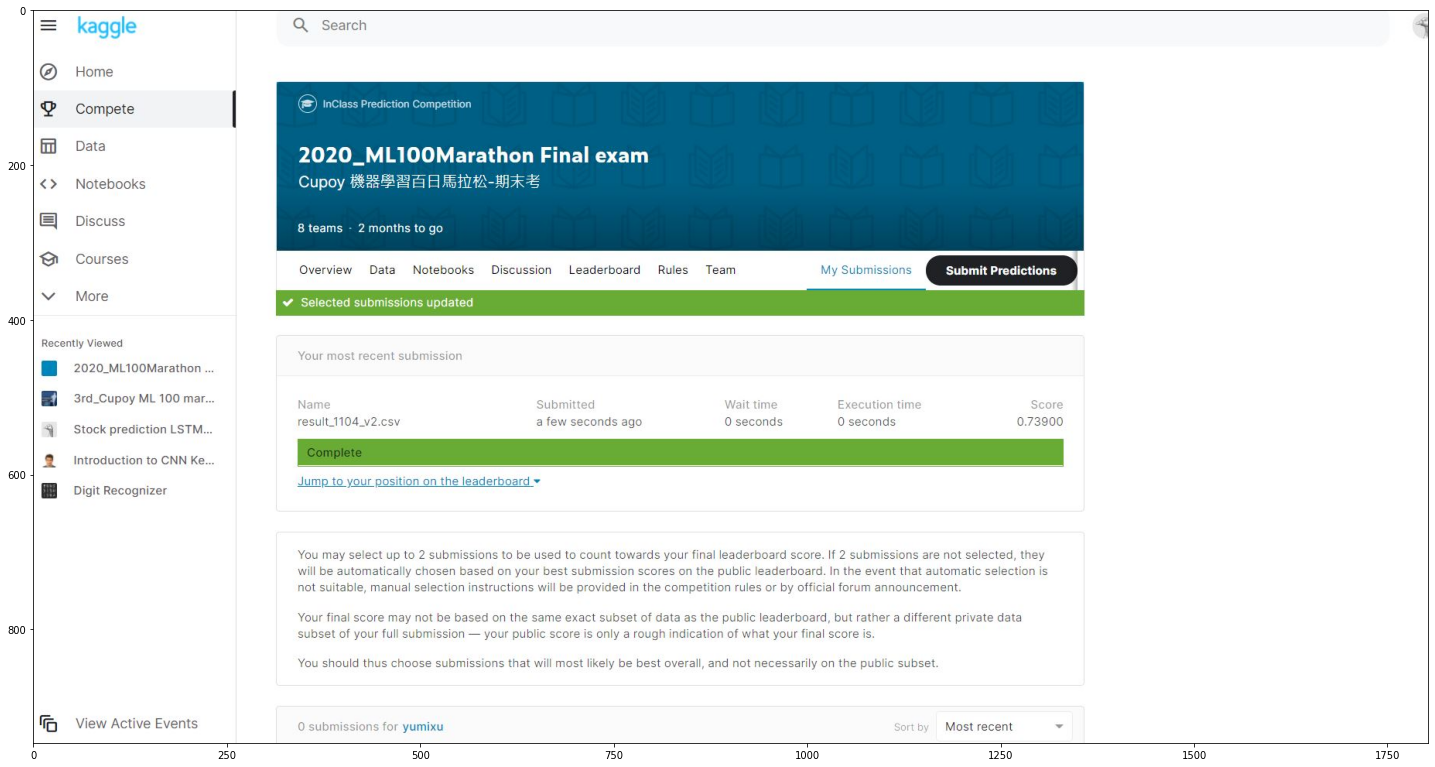

In [73]:
plt.figure(figsize=(25,25))
plt.imshow(mpimg.imread('CNN1104v1_73.JPG'))